# Business Bankruptcy Prediction

## Contents

1. Introduction
1. Preparation
1. Exploration
 1. Class Balance
 1. Dataset Structure
 1. Collinearity
1. Data Cleaning
 1. Missing Data
 1. Duplicates
 1. Outliers
1. Modelling
 1. Preprocessing
 1. Logistic Regression
 1. Decision Tree
 1. Random Forest
 1. Gradient Boosted Decision Tree
1. Model Evaluation and Interpretation
 1. Model Evaluation
 1. Model Interpretation
1. Conclusion

## Introduction

This dataset contains information on numerous companies, taken at the time of their assessment, and whether or not they went bankrupt within a year of the assessment. 

In this notebook we explore the dataset and construct a model to predict whether or not a company will file for bankruptcy in the next year.

## Preparation

Before we get started we need to make sure we're ready to go. We start by importing our necessary packages and loading our dataset. 

In [1]:
## core packages
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## statistical packages
from collections import Counter

## graphical packages
import seaborn as sns
import matplotlib.pyplot as plt

## preprocessing packages
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

## model packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

## model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve

We now load our dataset:

In [2]:
dataset = pd.read_csv("business_bankruptcy_prediction.csv")

We've loaded in our dataset, so lets see what it looks like:

In [3]:
dataset.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Company type,Bankruptcy
0,0.370594,0.424389,0.405750,0.601457,0.6014572133,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,Partnership,1
1,0.464291,0.538214,0.516730,0.610235,0.6102350855,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,Partnership,1
2,0.426071,0.499019,0.472295,0.601450,0.601363525,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,Partnership,1
3,0.399844,0.451265,0.457733,0.583541,0.5835411292,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,Partnership,1
4,0.465022,0.538432,0.522298,0.598783,0.5987834936,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,Limited Company,1


## Exploration

Our dataset is now imported, so we can start exploring it.

### Class Balance

The variable we're going to be predicting is the final column: bankruptcy. As we have a binary classification, i.e. did go bankrupt vs did not go bankrupt, it makes sense to explore the balance of the variable:

In [4]:
## we find the counts of the classes using the Counter
balance = Counter(dataset['Bankruptcy'])

## we now find the % of the dataset which goes bankrupt 
bankruptcyAmount = balance[1]/(balance[1]+balance[0])

print("{:.2%} of the dataset goes bankrupt".format(bankruptcyAmount))

3.23% of the dataset goes bankrupt


Our dataset has a balance problem - of the 6819 samples we have, only 3.23% of companies go bankrupt. That means that if we were to predict no company would go bankrupt, our initial accuracy would be 96.77%. This can lead us to believe or model is performing great, however in reality it is barely a model!

To combat this later on we'll have to use either class weights or sampling methods - I'll be using SMOTE syntheic oversampling.

### Dataset Structure

We can now inspect the rest of our data. When looking at its layout we can see there are some categoric columns, so we check our column make-up:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 97 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6818 non-null   float64
 3    Operating Gross Margin                                   6819 non-null   float64
 4    Realized Sales Gross Margin                              6818 non-null   object 
 5    Operating Profit Rate                                    6819 non-null   float64
 6    Pre-tax net Interest Rate                                6819 non-null   float64
 7    After-tax net Interest Rate                              6819 non-null   float64
 8    Non-industry inco

Looking at the above we can see some issues: we have some data types as objects where we shouldn't, and that some of our columns contain nulls. 

Let's see which of our columns contain null values:

In [6]:
## we iterate over the columns and find those with null values, we can see from above that they're very sparse
nullCols = [col for col in dataset if dataset[col].isna().sum() > 0]

nullCols 

[' ROA(B) before interest and depreciation after tax',
 ' Realized Sales Gross Margin',
 ' Net Value Per Share (C)',
 ' Per Share Net profit before tax (Yuan ¬•)',
 ' Regular Net Profit Growth Rate',
 ' Net Value Growth Rate',
 ' Inventory and accounts receivable/Net value',
 ' Inventory/Working Capital']

These are the 8 columns that contain null values, as our dataset is quite small we will impute values into the nulls rather than removing the columns altogether.

We now want to look at our object data and ensure they're correctly classed as categories or numbers:

In [7]:
objectCols = [col for col in dataset if dataset[col].dtypes == 'object'] 

objectCols

[' Realized Sales Gross Margin', ' Allocation rate per person', 'Company type']

These are our object columns, we can see below that Realized Sales Gross Margin and Allocation rate per person are in fact floats and are misclassified, and Company type is a category.

In [8]:
dataset[objectCols].head()

,Realized Sales Gross Margin,Allocation rate per person,Company type
0,0.6014572133,0.03713530158,Partnership
1,0.6102350855,0.01233497213,Partnership
2,0.601363525,0.1410163119,Partnership
3,0.5835411292,0.02131998974,Partnership
4,0.5987834936,0.02398821165,Limited Company


We check the first two columns for strings that may be causing the issue using regex, and set these values equal to NaN - we're going to be imputing values there anyway so we're safe to do that right now.

We ensure each value in the columns is equivalent to a number of the form X.X:

In [9]:
for col in dataset[objectCols[0:2]]:
    stringValue = dataset[col].str.match('^[+-]?\d*\.?\d+$', na=True)
    dataset[col] = dataset[col].mask(stringValue == False, np.NaN)

We can now fix the above by changing their classes:

In [10]:
dataset = dataset.astype({' Realized Sales Gross Margin':'float64', ' Allocation rate per person':'float64', 'Company type':'category'})

We can check our dataset again to ensure things look correct still:

In [11]:
dataset[objectCols].head()

,Realized Sales Gross Margin,Allocation rate per person,Company type
0,0.601457,0.037135,Partnership
1,0.610235,0.012335,Partnership
2,0.601364,0.141016,Partnership
3,0.583541,0.021320,Partnership
4,0.598783,0.023988,Limited Company


This fixed our issue, as suspected.

We now want to understand our dataset's make up, so we plot all variables using a histogram to get a feel for the data and see if we can spot any outliers:

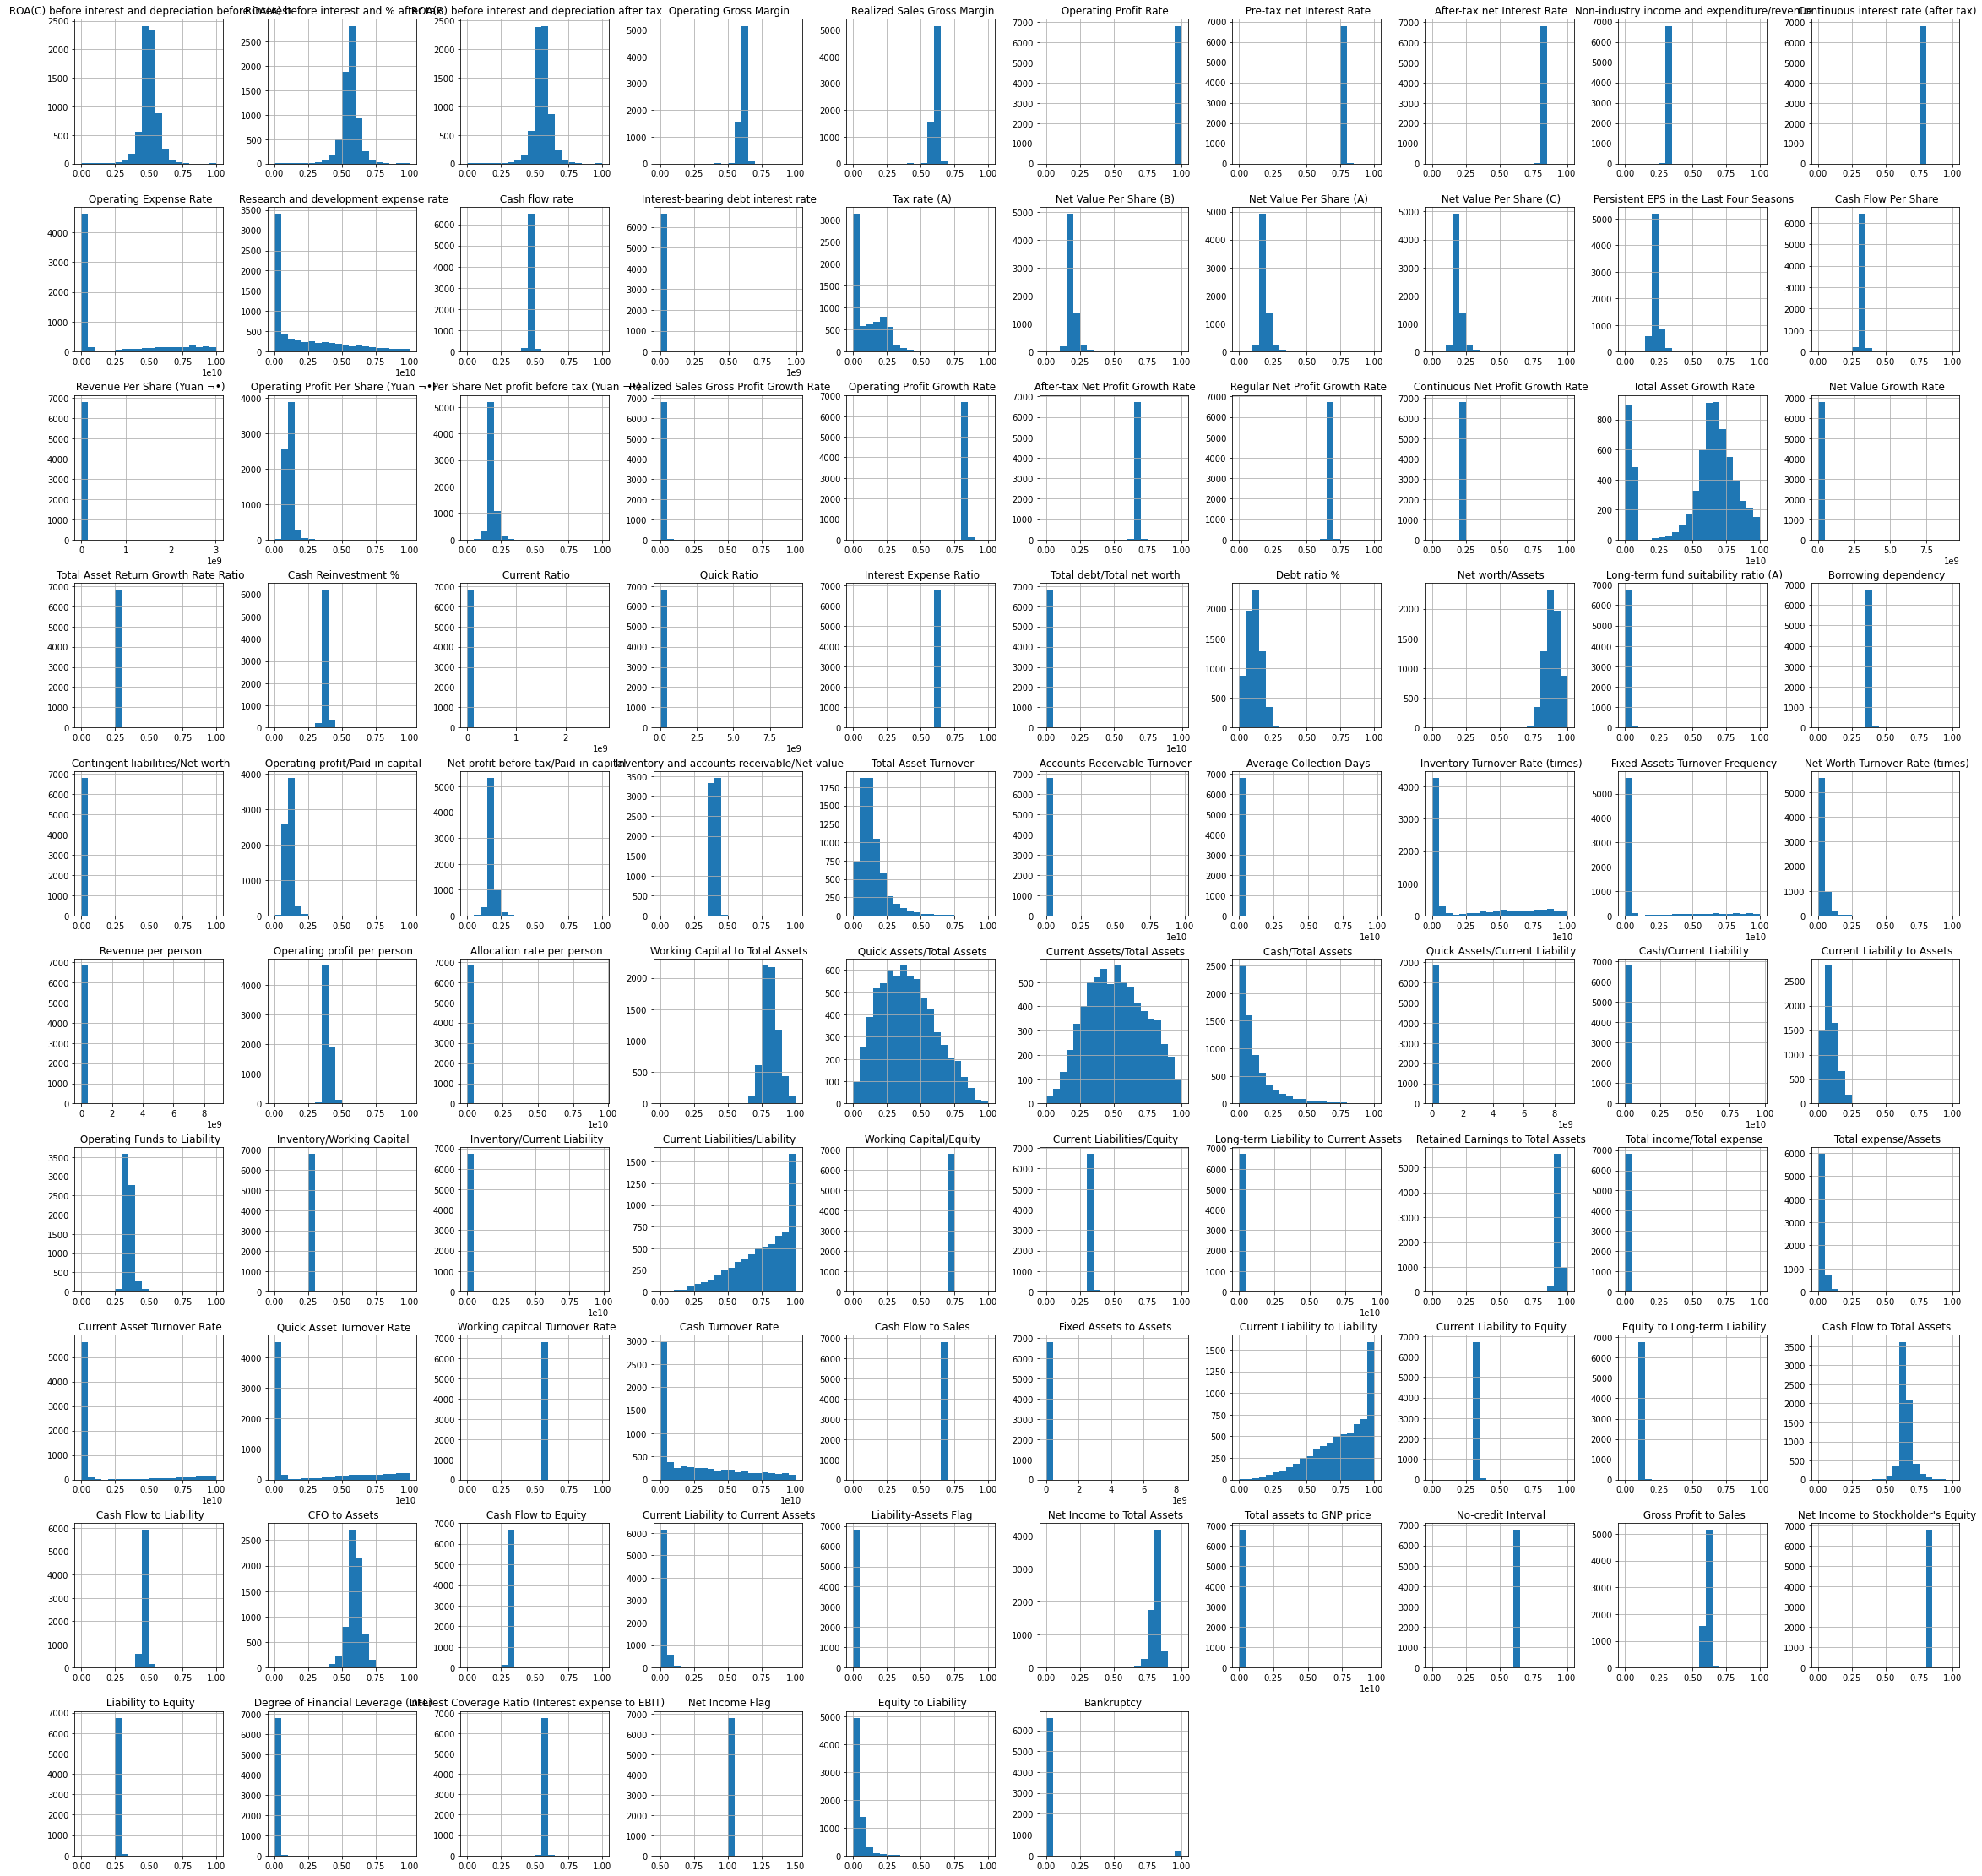

In [12]:
dataset.hist(figsize=(40,40), bins = 20)
plt.show()

We can see from gazing at the histograms above that our data contains a lot of outliers and extremal values. We'll look to deal with those later.

### Collinearity

Something else we need to care about is _multicollinearity_. This is when multiple columns are all highly correlated - this shouldn't affect our model's performance as model performance is robust to collinearity, it will however affect our ability to interpret the most important features of the model. 

For a regression model, as each variable is used, collinear variables reduce the importance of variables that are collinear. Were we to decide on a regression based model we'd have to take this effect into account, therefore we assess model performance before performing feature selection.

We'll also be using decision tree-based models to predict bankruptcy, decision trees are generally robust to collinearity as they work via _information gain_ at each application of the algorithm, therefore once a decision tree selects one of the collinear variables, the rest of our variables explain the same data and therefore don't explain anything new, and are therefore seen as less important.

We can visualise collinear variables with a heatmap:

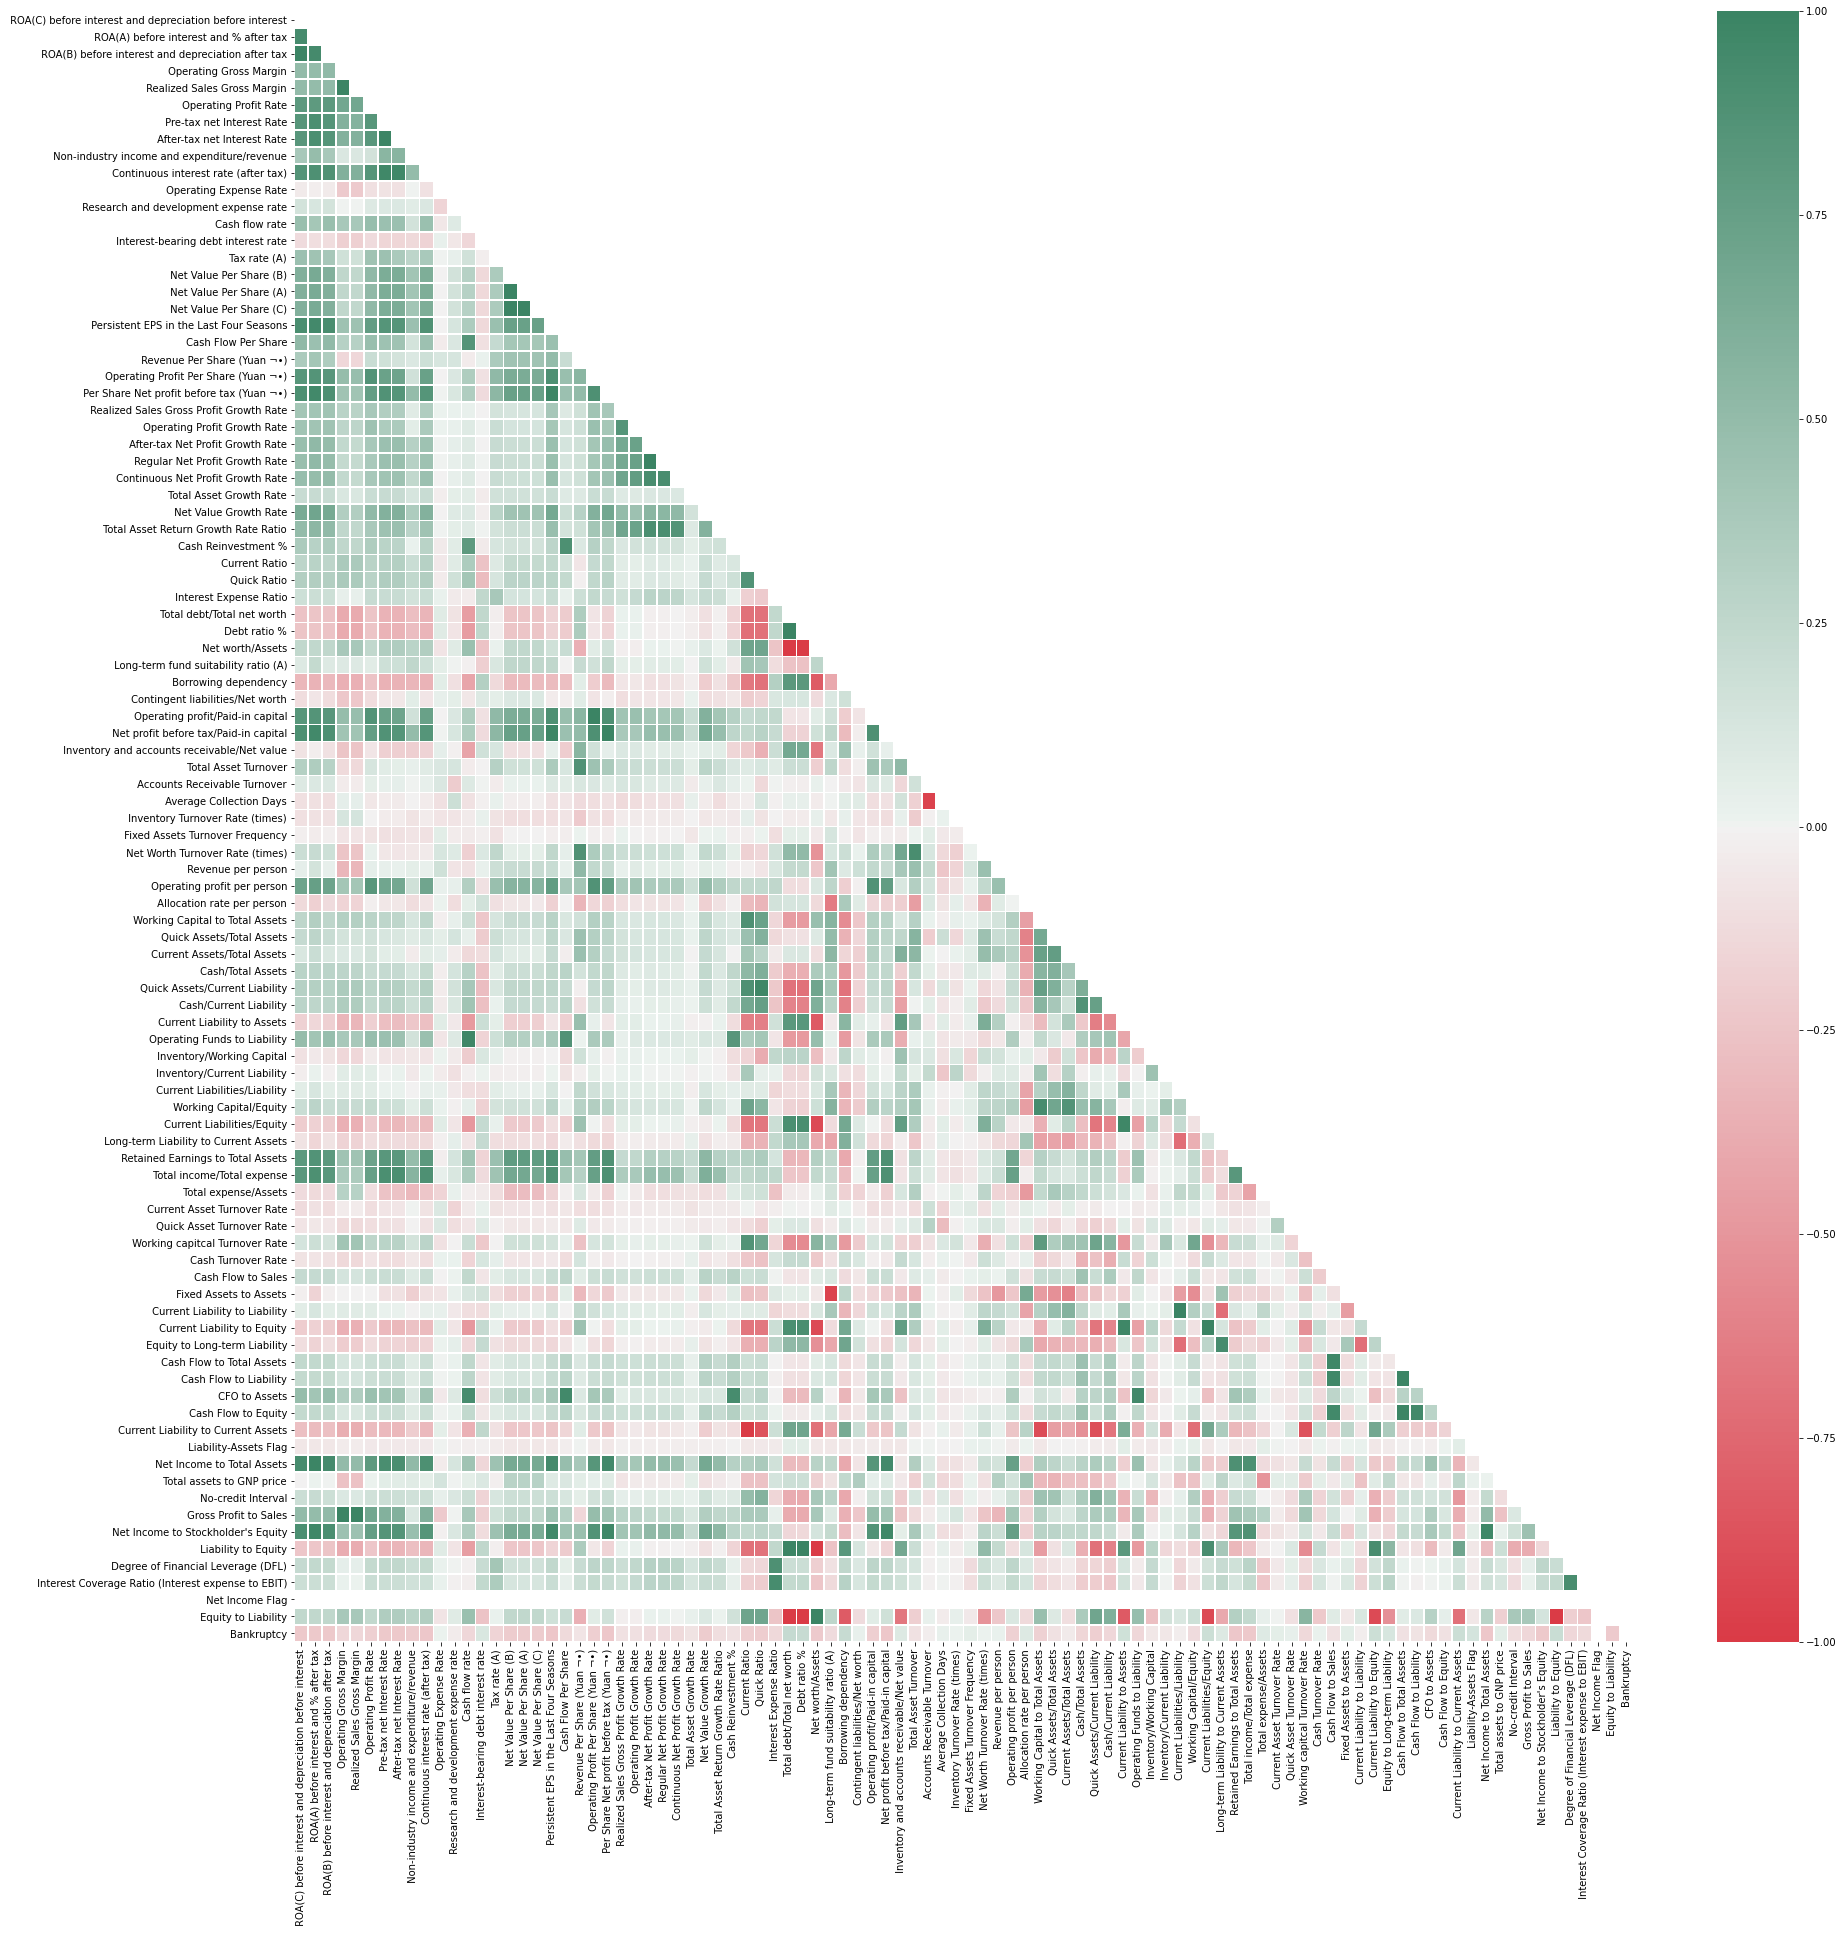

In [13]:
## finds the correlations
correlations = dataset.corr('spearman')

## we now define a mask to hide our duplicated correlations
mask = np.triu(np.ones_like(correlations, dtype=bool))
## then we define our colour palette to make the correlations more noticeable
cmap = sns.diverging_palette(10, 150, as_cmap=True)

## we now set out plot to be large enough to be interpretable
plt.subplots(figsize=(30, 30))
sns.heatmap(data = correlations, mask = mask, center = 0, cmap = cmap, linewidths= 0.5)
plt.show()

We can definitely see a lot of green in the graph, we can deal with these later.

## Data Cleaning

We've noticed above that we have some collinear variables, however we won't look to perform feature selection until we have a top performing model. This leaves us with a defined plan of action to clean our data:

1. Impute missing values with median
1. Check our data for duplicates
1. Impute outliers with the median
1. Fit our models and select the best performing
1. Handle collinear features

### Missing Data

As our dataset is already quite small, and since we have no nulls in our target column we choose to impute our missing values with the median rather than removing them completely.

In [14]:
datasetNoMissing = dataset.fillna(dataset.median())

This should've solved our missing value issue, we can rerun the code from earlier to check:

In [15]:
## we iterate over the columns and find those with null values, we can see from above that they're very sparse
nullCols = [col for col in datasetNoMissing if datasetNoMissing[col].isna().sum() > 0]

nullCols 

[]

### Duplicates

When handling our data we need to make sure the values our model sees are representative of the population it is sampled from, and stop our model overfitting. We therefore look to remove duplicate values:

In [16]:
datasetNoMissing = datasetNoMissing.drop_duplicates().reset_index(drop = True)

### Outliers

Another type of data that could affect our models could be outliers. Tree algorithms are robust to outliers, however regression models are not. We therefore define a function to remove outliers, and can test both a removed and non-removed model on our test data if we need to.

In [17]:
def outlier_impute(dataset):
    """
    dataset: pandas DataFrame
    
    This function removes outliers from a given dataframe.
    """
    for col in dataset:
        if dataset[col].dtype == 'float64':
            perc25 = np.percentile(dataset[col], 25)
            perc75 = np.percentile(dataset[col], 75)
            IQR = perc75 - perc25
            
            outlierRange = IQR * 1.5
            lowerBound = perc25 - outlierRange
            upperBound = perc75 + outlierRange
            dataset[col] = dataset[col].mask(~dataset[col].between(lowerBound, upperBound), dataset[col].median())
            
            print(col+"'s outliers fixed.")
        else:
            print("Non float column")
    
    return dataset

In [18]:
datasetNoOutliers = datasetNoMissing.copy()

outlier_impute(datasetNoOutliers)

 ROA(C) before interest and depreciation before interest's outliers fixed.
 ROA(A) before interest and % after tax's outliers fixed.
 ROA(B) before interest and depreciation after tax's outliers fixed.
 Operating Gross Margin's outliers fixed.
 Realized Sales Gross Margin's outliers fixed.
 Operating Profit Rate's outliers fixed.
 Pre-tax net Interest Rate's outliers fixed.
 After-tax net Interest Rate's outliers fixed.
 Non-industry income and expenditure/revenue's outliers fixed.
 Continuous interest rate (after tax)'s outliers fixed.
 Operating Expense Rate's outliers fixed.
 Research and development expense rate's outliers fixed.
 Cash flow rate's outliers fixed.
 Interest-bearing debt interest rate's outliers fixed.
 Tax rate (A)'s outliers fixed.
 Net Value Per Share (B)'s outliers fixed.
 Net Value Per Share (A)'s outliers fixed.
 Net Value Per Share (C)'s outliers fixed.
 Persistent EPS in the Last Four Seasons's outliers fixed.
 Cash Flow Per Share's outliers fixed.
 Revenue P

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Company type,Bankruptcy
0,0.502706,0.559802,0.552278,0.601457,0.601457,0.998969,0.797464,0.809375,0.303525,0.781635,...,0.622879,0.601453,0.841179,0.278778,0.026808,0.565252,1,0.016469,Partnership,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.623652,0.610237,0.839969,0.283846,0.026808,0.565252,1,0.020794,Partnership,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.797464,0.809375,0.303525,0.781635,...,0.623841,0.601449,0.836774,0.278778,0.026808,0.565252,1,0.016474,Partnership,1
3,0.399844,0.559802,0.457733,0.583541,0.583541,0.999022,0.797464,0.809375,0.303350,0.781635,...,0.622929,0.583538,0.841179,0.281721,0.026697,0.564663,1,0.023982,Partnership,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.623521,0.598782,0.839973,0.278514,0.026808,0.565252,1,0.035490,Limited Company,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890,Limited Company,0
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284,Partnership,0
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.033798,Limited Company,0
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009,Limited Company,0


Our dataset is now fixed and contains no outliers.

## Modelling

We now begin setting up modelling pipelines for our data. We initally split our data into train and test sets, and use k-fold cross validation to find multiple dev sets. 

### Preprocessing

#### Data Splitting

We split our data using a 70/30 split:

In [19]:
X = datasetNoOutliers.drop(labels = ['Bankruptcy'], axis = 1)
y = datasetNoOutliers[['Bankruptcy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 5)

#### Class Imbalance

We know our dataset is imbalanced, so we use SMOTE synthetic oversampling to combat this in our model training. We're using k-fold cross validation, so we must oversample our data in the context of the folds rather than as a whole, we can define our sampling strategy now and then perform it later.

In [20]:
smoteSampling = SMOTE(random_state = 4432, sampling_strategy = 1)

#### Categoric Encoding

While decision trees can interpret categoric data, sklearn's decision trees and random forests cannot. To aid in building regression and tree based models, we use One-Hot encoding on our dataset to make the categoric variables interpretable. As with the class imbalance, we do this within the context of our k-folds to stop data leakage, therefore we define our encoding strategy now.

In [21]:
categoricalFeatures = ['Company type']

ohEncoder = OneHotEncoder(handle_unknown='ignore')

encoder = ColumnTransformer([('One-Hot Encoder', OneHotEncoder(), categoricalFeatures)], remainder='passthrough')

#### Data Scaling

In order to speed up model convergence, we must also scale our data. To prevent data leakage we do this within the context of our k-folds, and define the scaling now.

In [22]:
scaler = MinMaxScaler(feature_range = (0,1))

### Logistic Regression

We now build a simple logistic regression model. We select our best parameters by iterating through a list of them, and choosing the parameters with the best mean score of 5 different folds.

We start by importing modules to hide convergence warnings which can crop up in logistic regression:

In [23]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Now we define our model and the parameter search with it:

In [24]:
lr = LogisticRegression()

lrParams = {
    'LR__C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'LR__solver': ['lbfgs','liblinear']
}

We've now got a small block of parameters to iterate over, we now set up our random search, using 10 iterations, and using ROC AUC as our scoring system. ROC AUC is a measure of our false positives to true positives.

In [25]:
y_train_unraveled = y_train.values.ravel()

lrPipe = Pipeline(steps = [('One-Hot Encoding', encoder),
                           ('SMOTE sampling', smoteSampling),
                           ('Min-Max scaling', scaler),
                           ('LR', lr)])

lrGrid = RandomizedSearchCV(lrPipe, param_distributions = lrParams, n_iter = 10, scoring = 'roc_auc')
lrFit = lrGrid.fit(X_train, y_train_unraveled)
lrBP = lrFit.best_params_
print(lrBP)    
print(lrFit.best_score_)

{'LR__solver': 'lbfgs', 'LR__C': 0.01}
0.9161002433378626


We run a quick classification report also, using our best parameters:

In [26]:
lrPreds = lrFit.best_estimator_.predict(X_test)
y_test_unraveled = y_test.values.ravel()

print(classification_report(y_test_unraveled, lrPreds))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1980
           1       0.16      0.86      0.27        66

    accuracy                           0.85      2046
   macro avg       0.58      0.86      0.59      2046
weighted avg       0.97      0.85      0.90      2046



This score isn't too bad! We can try other models before we expand on logistic regression more.

### Decision Tree

A decision tree is a very simple model that chooses to split our data in two based on the variable that would provide the most _information_ on the model in each split. We then split each of the splits and continue until our max depth.

We want to find the best decision tree possible, so we use a grid search to find the most promising hyperparameters as we did with logistic regression:

In [27]:
dt = DecisionTreeClassifier()

dtParams = {
    'DT__criterion': ['gini','entropy'],
    'DT__max_depth': [2,4,6,8,10,20,30],
    'DT__max_features': ['sqrt','log2']
}

In [28]:
dtPipe = Pipeline(steps = [('One-Hot Encoding', encoder),
                           ('SMOTE sampling', smoteSampling),
                           ('Min-Max scaling', scaler),
                           ('DT', dt)])

dtGrid = RandomizedSearchCV(dtPipe, param_distributions = dtParams, n_iter = 25, scoring = 'roc_auc')
dtFit = dtGrid.fit(X_train, y_train_unraveled)
print(dtFit.best_params_)    
print(dtFit.best_score_)

{'DT__max_features': 'sqrt', 'DT__max_depth': 4, 'DT__criterion': 'entropy'}
0.86622092443878


We can build a classification report as before for our best performing model:

In [29]:
dtPreds = dtFit.best_estimator_.predict(X_test)

print(classification_report(y_test_unraveled, dtPreds))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1980
           1       0.12      0.85      0.21        66

    accuracy                           0.80      2046
   macro avg       0.56      0.82      0.55      2046
weighted avg       0.97      0.80      0.86      2046



### Random Forests

A random forest is a collection of decision trees, where we take the most common value that a number of them output. 

We start as before where we take a selection of parameters and randomly search a grid of them for values:

In [30]:
rf = DecisionTreeClassifier()

rfParams = {
    'RF__criterion': ['gini','entropy'],
    'RF__max_depth': [2,4,6,8,10,20,30],
    'RF__max_features': ['auto','sqrt','log2']
}

In [31]:
rfPipe = Pipeline(steps = [('One-Hot Encoding', encoder),
                           ('SMOTE sampling', smoteSampling),
                           ('Min-Max scaling', scaler),
                           ('RF', rf)])

rfGrid = RandomizedSearchCV(rfPipe, param_distributions = rfParams, n_iter = 25, scoring = 'roc_auc')
rfFit = rfGrid.fit(X_train, y_train_unraveled)
print(rfFit.best_params_)    
print(rfFit.best_score_)

{'RF__max_features': 'auto', 'RF__max_depth': 4, 'RF__criterion': 'gini'}
0.8655632859744626


And now we predict with our best parameters:

In [32]:
rfPreds = rfFit.best_estimator_.predict(X_test)

print(classification_report(y_test_unraveled, rfPreds))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1980
           1       0.13      0.62      0.22        66

    accuracy                           0.86      2046
   macro avg       0.56      0.74      0.57      2046
weighted avg       0.96      0.86      0.90      2046



### Gradient Boosted Decision Trees

Like how random forests combine a lot of decision trees to produce a value, as do gradient boosted models. RF's however use the output from every decision tree at the same time and use the most common answer, however GBDTs use each decision tree sequentially and overcorrect for the values the previous decision tree fumbled. This allows our model to constantly correct itself and tends to produce a very strong output.

We use two boosted algorithms: Light GBM and CatBoost.

Light GBM builds its trees leafwise, whereas CatBoost builds its trees in a balanced way.

#### Light GBM

We define our parameters below:

In [33]:
lgb = LGBMClassifier()

lgbParams = {
    'LGB__reg_alpha': [1e-3,1e-2,1e-1,0,1e1,1e2,1e3],
    'LGB__reg_lambda': [1e-3,1e-2,1e-1,0,1e1,1e2,1e3],
    'LGB__num_leaves': [5,15,25,35,45,55],
    'LGB__learning_rate': [1e-3,1e-2,1e-1]
}

Run our grid search as is standard:

In [34]:
lgbPipe = Pipeline(steps = [('One-Hot Encoding', encoder),
                           ('SMOTE sampling', smoteSampling),
                           ('Min-Max scaling', scaler),
                           ('LGB', lgb)])

lgbGrid = RandomizedSearchCV(lgbPipe, param_distributions = lgbParams, n_iter = 25, scoring = 'roc_auc')
lgbFit = lgbGrid.fit(X_train, y_train_unraveled)
print(lgbFit.best_params_)    
print(lgbFit.best_score_)

{'LGB__reg_lambda': 100.0, 'LGB__reg_alpha': 0.1, 'LGB__num_leaves': 25, 'LGB__learning_rate': 0.1}
0.9345609080706764


And predict using our best fit:

In [35]:
lgbPreds = lgbFit.best_estimator_.predict(X_test)

print(classification_report(y_test_unraveled, lgbPreds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1980
           1       0.32      0.52      0.40        66

    accuracy                           0.95      2046
   macro avg       0.65      0.74      0.69      2046
weighted avg       0.96      0.95      0.96      2046



This is our best result yet.

#### CatBoost

In [36]:
cgb = CatBoostClassifier()

cgbParams = {
    'CGB__depth': [4, 6, 8, 10],
    'CGB__l2_leaf_reg': [1e-3,1e-2,1e-1,0,1e1,1e2,1e3],
    'CGB__learning_rate': [1e-3,1e-2,1e-1],
    'CGB__verbose': [False],
    'CGB__iterations': [100],
    'CGB__task_type': ['GPU']
}

In [37]:
cgbPipe = Pipeline(steps = [('One-Hot Encoding', encoder),
                           ('SMOTE sampling', smoteSampling),
                           ('Min-Max scaling', scaler),
                           ('CGB', cgb)])

cgbGrid = RandomizedSearchCV(cgbPipe, param_distributions = cgbParams, n_iter = 25, scoring = 'roc_auc')
cgbFit = cgbGrid.fit(X_train, y_train_unraveled)
print(cgbFit.best_params_)    
print(cgbFit.best_score_)

{'CGB__verbose': False, 'CGB__task_type': 'GPU', 'CGB__learning_rate': 0.1, 'CGB__l2_leaf_reg': 0.1, 'CGB__iterations': 100, 'CGB__depth': 10}
0.9298412272265066


And predicting:

In [38]:
cgbPreds = cgbFit.best_estimator_.predict(X_test)

print(classification_report(y_test_unraveled, cgbPreds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1980
           1       0.34      0.33      0.34        66

    accuracy                           0.96      2046
   macro avg       0.66      0.66      0.66      2046
weighted avg       0.96      0.96      0.96      2046



## Model Evaluation and Interpretation

So far we've built 5 models to detect bankruptcy in companies. We can now look at their performances in context, and then select which model is best. After selecting our best model we can look at the feature importance to give context to the model.

### Model Evaluation

We produce ROC-AUC and Precision-Recall curves to help evaluate our models - these models take the probability an entry belongs to a our positive class and vary the thresholds for which we say it belongs to the class, after we plot the curve we can see how the model performs and select an optimum threshold if we like.

#### ROC-AUC Curves

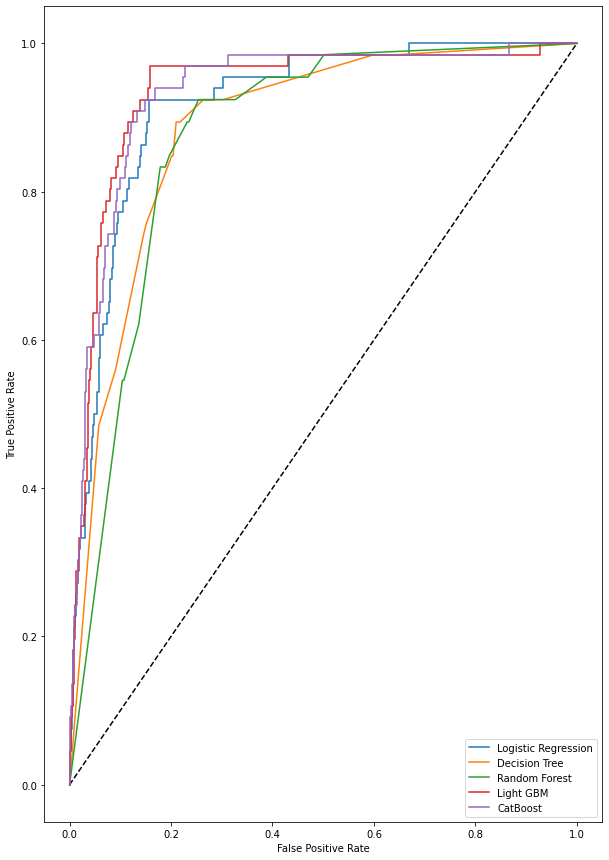

In [40]:
## We find our probabilities
lrProbs = lrFit.best_estimator_.predict_proba(X_test)[:,1]
dtProbs = dtFit.best_estimator_.predict_proba(X_test)[:,1]
rfProbs = rfFit.best_estimator_.predict_proba(X_test)[:,1]
lgbProbs = lgbFit.best_estimator_.predict_proba(X_test)[:,1]
cgbProbs = cgbFit.best_estimator_.predict_proba(X_test)[:,1]

## Next our ROC-AUC curve
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test_unraveled, lrProbs)
dt_fpr, dt_tpr, dt_threshold = roc_curve(y_test_unraveled, dtProbs)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test_unraveled, rfProbs)
lgb_fpr, lgb_tpr, lgb_threshold = roc_curve(y_test_unraveled, lgbProbs)
cgb_fpr, cgb_tpr, cgb_threshold = roc_curve(y_test_unraveled, cgbProbs)

## We now plot our graphs
plt.figure(figsize=(10, 15))
## Now our baseline
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.plot(lgb_fpr, lgb_tpr, label='Light GBM')
plt.plot(cgb_fpr, cgb_tpr, label='CatBoost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='best')

Our two gradient boosted trees have the best ROC-AUC curves, however their performance will have to be evaluated in context.

#### Precision-Recall Curves

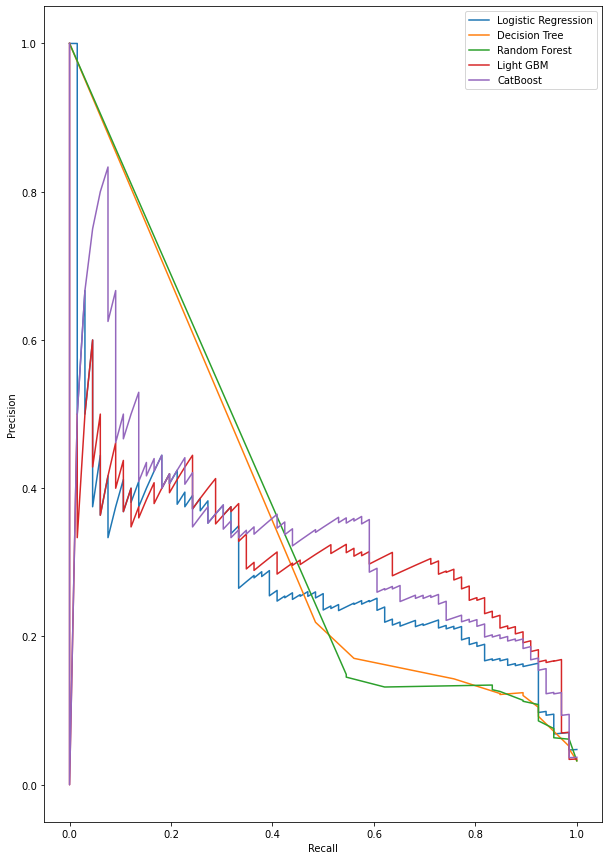

In [41]:
## Now our Precision-Recall curve
lr_precision, lr_recall, lr_pr_threshold = precision_recall_curve(y_test_unraveled, lrProbs)
dt_precision, dt_recall, dt_pr_threshold = precision_recall_curve(y_test_unraveled, dtProbs)
rf_precision, rf_recall, rf_pr_threshold = precision_recall_curve(y_test_unraveled, rfProbs)
lgb_precision, lgb_recall, lgb_pr_threshold = precision_recall_curve(y_test_unraveled, lgbProbs)
cgb_precision, cgb_recall, cgb_pr_threshold = precision_recall_curve(y_test_unraveled, cgbProbs)

## We now plot our graphs
plt.figure(figsize=(10, 15))

plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(dt_recall, dt_precision, label='Decision Tree')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(lgb_recall, lgb_precision, label='Light GBM')
plt.plot(cgb_recall, cgb_precision, label='CatBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='best')

#### Confusion Matrices

As well as our ROC-AUC and Precision-Recall curves, it's important contextually to look at our models' confusion matrices, as we want to use the model which has the highest precision for our bankruptcy flag.

We plot them below:

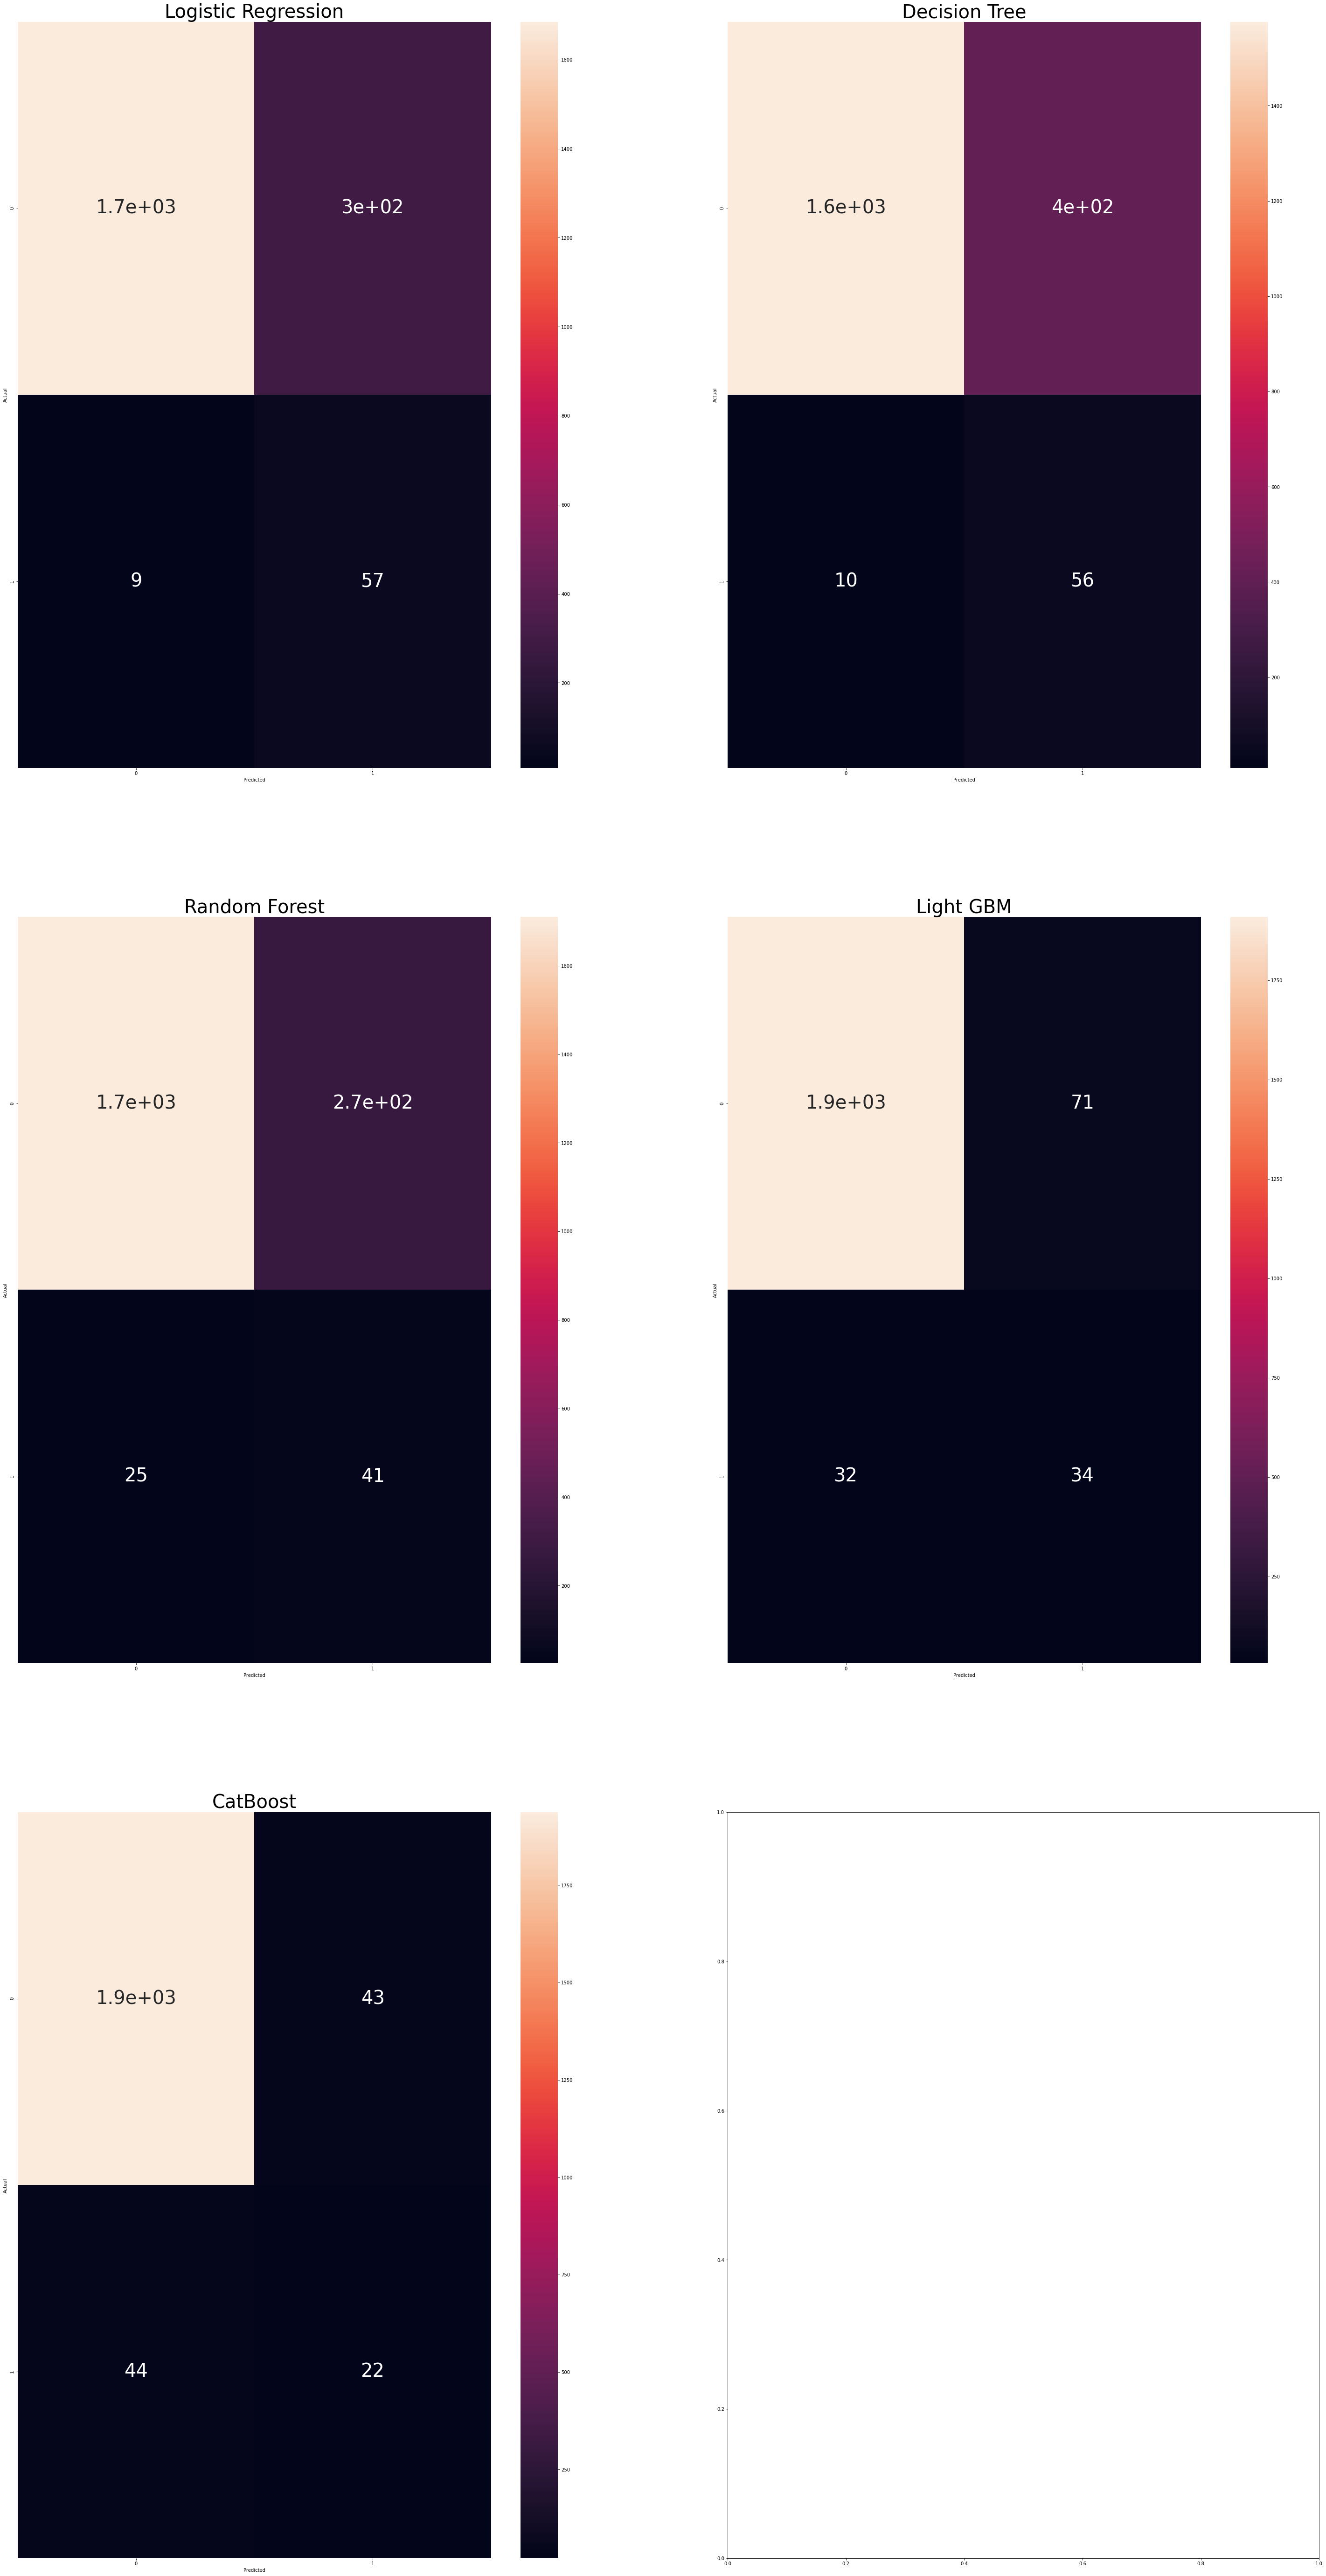

In [42]:
cf_lr = confusion_matrix(y_test_unraveled, lrPreds, labels = [0,1])
cf_dt = confusion_matrix(y_test_unraveled, dtPreds, labels = [0,1])
cf_rf = confusion_matrix(y_test_unraveled, rfPreds, labels = [0,1])
cf_lgb = confusion_matrix(y_test_unraveled, lgbPreds, labels = [0,1])
cf_cgb = confusion_matrix(y_test_unraveled, cgbPreds, labels = [0,1])

def heatmap(cf):
    """
    cf: sklearn confusion matrix
    
    This function takes an input confusion matrix and maps it nicely to a labelled DataFrame
    """
    cf_df = pd.DataFrame(cf, columns = [0,1], index = [0,1])
    cf_df.index.name = 'Actual'
    cf_df.columns.name = 'Predicted'
    
    return cf_df

## We set our config for our plot
fig, ax = plt.subplots(3, 2, figsize=(50,100))
ax[0]
## We now plot heatmaps for each of our confusion matrices
sns.heatmap(heatmap(cf_lr), annot = True, ax = ax[0][0], annot_kws={"size": 40})
ax[0][0].set_title('Logistic Regression', fontsize = 40)
sns.heatmap(heatmap(cf_dt), annot = True, ax = ax[0][1], annot_kws={"size": 40})
ax[0][1].set_title('Decision Tree', fontsize = 40)
sns.heatmap(heatmap(cf_rf), annot = True, ax = ax[1][0], annot_kws={"size": 40})
ax[1][0].set_title('Random Forest', fontsize = 40)
sns.heatmap(heatmap(cf_lgb), annot = True, ax = ax[1][1], annot_kws={"size": 40})
ax[1][1].set_title('Light GBM', fontsize = 40)
sns.heatmap(heatmap(cf_cgb), annot = True, ax = ax[2][0], annot_kws={"size": 40})
ax[2][0].set_title('CatBoost', fontsize = 40)

plt.show()

Looking at the above, it seems like we should choose the logistic regression model as it correctly classifies the most of companies that go bankrupt - while its accuracy isn't the best in the context of the business it makes more sense to use this model.

### Model Interpretation

We find feature importance using our regression coefficients, as our values are scaled equally before they go into the model, their coefficients provide an estimate to their importance:

In [43]:
cats = ohEncoder.fit(X_train[['Company type']]).categories_[0]
static = X_train.drop(['Company type'], axis = 1).columns.values
column_names = [*cats,*static]

In [44]:
importances = pd.DataFrame(abs(lrFit.best_estimator_['LR'].coef_[0].reshape(1,-1)), columns = column_names, index = ['Importance'])
importances.T.sort_values(by = 'Importance', ascending = False)

,Importance
Total income/Total expense,0.939478
Interest-bearing debt interest rate,0.853300
Debt ratio %,0.637561
Net worth/Assets,0.637519
Inventory/Working Capital,0.610006
...,...
Fixed Assets Turnover Frequency,0.022617
Inventory and accounts receivable/Net value,0.021301
Equity to Long-term Liability,0.012531
Research and development expense rate,0.003363


## Conclusion

In this notebook we have created a model to predict whether or not a company will go bankrupt. While all our models performed well, we decide to use a model which _wasn't_ the best - using a model with a high recall will allow us to ensure we don't lose money due to excess companies going bankrupt, therefore we use the Logistic Regression model.

The final performance of the model is as follows:

In [45]:
print(classification_report(y_test_unraveled, lrPreds))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1980
           1       0.16      0.86      0.27        66

    accuracy                           0.85      2046
   macro avg       0.58      0.86      0.59      2046
weighted avg       0.97      0.85      0.90      2046



Looking at the feature importance values for the model tells us that the most important features for predicting bankruptcy are: Total income/Total expense, Interest-bearing debt interest rate, Debt ratio %, Net worth/Assets, and Inventory/Working Capital. Were we to have more time we could remove collinear variables and have a truer view of feature importance, and use SHAP values for feature importance.